## 0. Setup

### 0.1. Import

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
from utils.visualization import visualize

### 0.2 Verify GPU access

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Data

### 1.1. Create a dataset

In [3]:
RANDOM_SEED = 42
N = 100 # num of pts per class
D = 2 # dim
K = 3 # num of classes
X = np.zeros((N*K,D)) # input matrix
y = np.zeros(N*K, dtype='uint8') # class labels

In [4]:
import numpy as np
np.random.seed(RANDOM_SEED)
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

In [5]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

### 1.2. Split data into training & test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

### 1.3. Visualize data

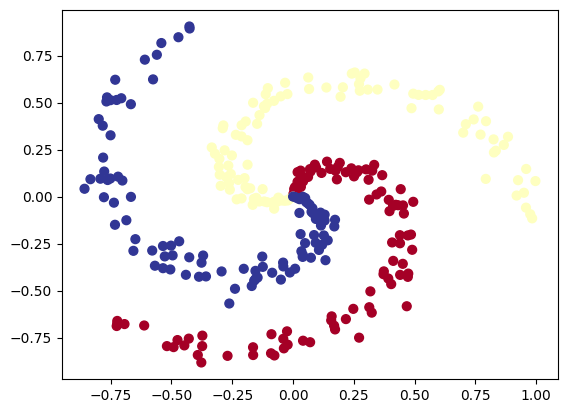

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

## 2. Build a model

### 2.1. Model Class Creation
   - `SpiralModel`: multi-layer perceptrons (MLPs), capable of learning complex, non-linear relationships like a spiral shape.

In [8]:
class SpiralModel(nn.Module): 
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

In [9]:
model = SpiralModel().to(device)
model

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

## 3. Training

### 3.1. Initialize Loss Function & Optimizer
- **Loss Function**:
  - **`nn.CrossEntropyLoss`**:
    - Combines `nn.LogSoftmax` and `nn.NLLLoss` in one step for multi-class classification.
    - Suitable for tasks where the target has multiple classes.

- **Optimizer**:
  - **`torch.optim.Adam`**:
    - Optimization method: Adaptive Moment Estimation (Adam), which adapts learning rates for each parameter.
    - Learning Rate: `0.02`.

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.02)

### 3.2. Optimization Loop

In [11]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)

for epoch in range(epochs):
  ## Training
  model.train()

  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)
  
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.13 Acc: 0.35 | Test loss: 1.13 Test acc: 0.27
Epoch: 100 | Loss: 0.24 Acc: 0.90 | Test loss: 0.23 Test acc: 0.93
Epoch: 200 | Loss: 0.04 Acc: 0.99 | Test loss: 0.02 Test acc: 1.00
Epoch: 300 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 400 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 500 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 600 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 700 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 900 | Loss: 0.01 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00


### 3.3. Evaluation

In [12]:
y_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {acc_fn(y_preds, y_test)*100}%")

Predictions: tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1], device='cuda:0')
Test accuracy: 100.0%


### 3.4. Visualization

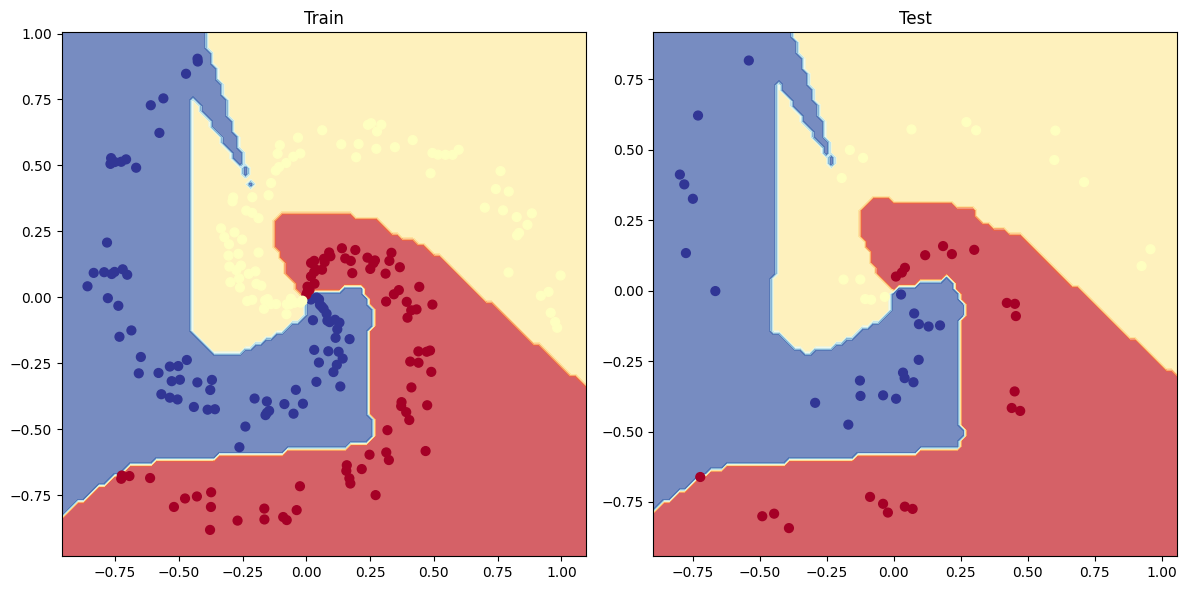

In [13]:
visualize(model, X_train, y_train, X_test, y_test)